## Preprocessing

In [539]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import json
import time
import random

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [540]:
TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1
TIME_WINDOW_SIZE = 12
EPOCHS = 200

NUMBER_OF_CLIENTS = 50

In [541]:
def prepare_weather():
  weather = pd.read_csv('weather.csv', parse_dates=[3])
  weather = weather[weather['time'].dt.strftime('%Y') == '2013'].sort_values(by=['time'])
  weather = weather.set_index('time')
  weather = weather[['temperature', 'humidity']]
  return weather

def load_data():
    df = pd.read_csv('combined.csv', parse_dates=[1])
    return df

def basic_preprocess_fn(df:pd.DataFrame):
    """ Selects the electricity data with standard tariffs belonging to year 2013 and sorts the dataframe based on 
    DateTime column. """
    
    temp = df[df['DateTime'].dt.strftime('%Y') == '2013'].sort_values(by=['DateTime'])
    #temp = temp[temp['stdorToU'] == 'Std']
    #temp = temp.drop(axis=1, columns = 'stdorToU')
    return temp

# ***************** IMPORTANT ABOVE: ONLY CLIENT AND ENERGY COLUMNS REMAIN. PUT THE CLIENTS AS COLUMNS, AND RESAMPLE THE DATASET AFTERWARDS. ******************

def extract_clients(df:pd.DataFrame):
    """ Extracts client ids and client data from the given dataframe, which is assumed to hold multiple 
    client information."""
    
    client_keys = df['LCLid'].value_counts().keys().tolist()
    client_list = []

    for key in client_keys:
        client_df = df[df['LCLid'] == key]
        client_list.append(client_df)

    return client_keys, client_list

def resample_fn(df:pd.DataFrame):
    """ Resamples the time-series dataframe so that it reflects hourly electricity consumption values. It also does
    basic data processing such as dropping unnecessary columns. """
    
    resample_df = df.astype({"KWH/hh (per half hour) ": float}).drop(columns = ['LCLid']).set_index('DateTime').resample(rule='H').sum()
    resample_df.rename(columns = {'KWH/hh (per half hour) ':'kWh'}, inplace = True)
    return resample_df

def remove_bad_clients(client_keys:list, client_list:list):
    """ Drops the clients with datapoints fewer than 0.9 percent of the client with highest amount of data. """
    
    sizes = [len(e) for e in client_list]
    biggest_client = max(sizes) 
    ratios = [size/biggest_client for size in sizes]
    indices_to_keep = [idx for idx,e in enumerate(ratios) if e==1]
    
    client_keys_selected = [client_keys[index] for index in indices_to_keep]
    client_list_selected = [client_list[index] for index in indices_to_keep]
    
    return client_keys_selected, client_list_selected

def create_client_dict(client_keys, client_data_list):
    """ Matches every client ID with its own electricty consumption data and returns the pairs in a python dictionary. """
    client_dict = {}
    for key, df in zip(client_keys, client_data_list):
        client_dict[key] = df
        
    return client_dict

In [542]:
df = load_data()
temp = basic_preprocess_fn(df)
client_keys, client_list = extract_clients(temp)
client_list_resampled = list(map(resample_fn, client_list))
client_keys_selected, client_list_selected = remove_bad_clients(client_keys, client_list_resampled)
client_dict = create_client_dict(client_keys_selected, client_list_selected)
weather = prepare_weather()

In [543]:
t = pd.DataFrame()
for k,v in client_dict.items():
  t[k] = v

t_new = t.copy()
t_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


,MAC001302,MAC001816,MAC001367,MAC002170,MAC004463,MAC001266,MAC002172,MAC001819,MAC001845,MAC004470,...,MAC001839,MAC002195,MAC001836,MAC001295,MAC002206,MAC002177,MAC002175,MAC004483,MAC001843,MAC001841
DateTime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.168,0.139,0.306,0.342,0.322,0.207,0.116,0.251,0.065,0.057,...,0.235,0.317,0.813,0.143,0.083,0.326,0.247,0.049,0.675,0.354
2013-01-01 01:00:00,0.058,0.081,0.223,0.163,0.323,0.061,0.034,0.090,0.070,0.143,...,0.156,0.160,0.529,0.178,0.065,0.275,0.041,0.218,0.608,0.269
2013-01-01 02:00:00,0.100,0.077,0.248,0.152,0.322,0.023,0.101,0.081,0.145,0.054,...,0.211,0.155,0.567,0.189,0.075,0.165,0.043,0.104,0.737,0.114
2013-01-01 03:00:00,0.053,0.073,0.998,0.152,0.324,0.024,0.076,0.279,0.059,0.089,...,0.243,0.155,0.783,0.185,0.079,0.137,0.042,0.106,0.621,0.109
2013-01-01 04:00:00,0.017,0.057,0.278,0.208,0.468,0.024,0.040,0.106,0.061,0.110,...,0.156,0.144,0.653,0.150,0.051,0.181,0.042,0.109,0.592,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.378,0.314,0.603,0.267,0.388,0.839,0.415,1.221,0.165,0.121,...,0.591,0.355,0.876,0.710,0.364,0.429,1.162,0.682,1.388,0.386
2013-12-31 20:00:00,0.426,0.260,0.350,0.317,0.212,1.401,0.383,0.931,0.159,0.054,...,0.652,0.276,0.882,0.652,0.280,0.443,1.165,0.634,0.962,0.366
2013-12-31 21:00:00,0.772,0.284,0.344,0.312,0.263,1.641,0.305,1.090,0.158,0.033,...,0.847,0.161,0.817,0.672,0.208,0.387,1.208,0.117,0.659,0.399


In [544]:
t_new = t_new.sample(n=NUMBER_OF_CLIENTS, axis='columns')

In [545]:
t_new['temperature'] = weather['temperature']
t_new['humidity'] = weather['humidity']
t_new = t_new[:4380]

t_new['hour'] = t_new.index.hour
t_new['day_of_week'] = t_new.index.dayofweek
t_new['week_of_year'] = t_new.index.isocalendar().week

t_new

,MAC001848,MAC001377,MAC002192,MAC001816,MAC002170,MAC004481,MAC001276,MAC001824,MAC004475,MAC001272,...,MAC002197,MAC004483,MAC004464,MAC002208,MAC001362,temperature,humidity,hour,day_of_week,week_of_year
DateTime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.925,1.372,0.209,0.139,0.342,0.131,0.063,0.295,0.943,0.018,...,0.028,0.049,0.883,1.508,0.104,7.01,0.73,0,1,1
2013-01-01 01:00:00,0.778,0.142,0.272,0.081,0.163,0.226,0.127,0.301,0.126,0.017,...,0.049,0.218,1.337,0.573,0.022,7.49,0.72,1,1,1
2013-01-01 02:00:00,0.588,0.128,0.358,0.077,0.152,0.278,0.135,0.446,0.105,0.101,...,0.042,0.104,1.351,0.564,0.031,7.16,0.68,2,1,1
2013-01-01 03:00:00,0.709,0.137,0.204,0.073,0.152,0.273,0.088,0.236,0.076,0.013,...,0.036,0.106,1.344,0.481,0.037,7.04,0.68,3,1,1
2013-01-01 04:00:00,0.598,0.124,0.237,0.057,0.208,0.161,0.121,0.239,0.095,0.034,...,0.105,0.109,1.363,0.566,0.041,6.29,0.73,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-02 07:00:00,0.273,0.254,0.254,0.229,0.463,1.013,1.901,0.678,0.204,0.431,...,0.060,0.059,0.098,0.275,0.119,14.26,0.75,7,1,27
2013-07-02 08:00:00,0.108,0.422,0.232,0.126,0.132,1.047,1.043,0.274,0.073,0.429,...,0.048,0.075,0.344,0.429,0.592,14.79,0.70,8,1,27
2013-07-02 09:00:00,0.087,0.437,0.381,0.195,0.480,0.072,0.000,0.577,0.094,0.964,...,0.051,0.064,0.284,0.353,0.258,15.31,0.68,9,1,27


## Creating Tensors

In [546]:
def train_test_val_split(df):
  """ Splits the client data into train, test and validation datasets. """

  df_size = df.shape[0]

  train = df.iloc[:int(df_size * 0.7)]
  val = df.iloc[int(df_size * 0.7):int(df_size * 0.9)]
  test = df.iloc[int(df_size * 0.9):]

  return train, val, test

def normalize_fn(train, val, test, scaler = MinMaxScaler()):
  """ Normalizes the input arrays with the given scaler. Train array is taken as the reference. """
  #energy_columns = list(t_new.columns[:-5].values)

  #train[energy_columns] = scaler.fit_transform( train[energy_columns].values )
  #val[energy_columns] = scaler.transform( val[energy_columns].values )
  #test[energy_columns] = scaler.transform( test[energy_columns].values )

  train_sc = scaler.fit_transform( train.values )
  val_sc = scaler.fit_transform( val.values )
  test_sc = scaler.fit_transform( test.values )
  scaler = scaler
  
  return train_sc, val_sc, test_sc, scaler

In [547]:
train, val, test = train_test_val_split(t_new)

In [548]:
train_sc, val_sc, test_sc, scaler = normalize_fn(train, val, test)

In [549]:
train

,MAC001848,MAC001377,MAC002192,MAC001816,MAC002170,MAC004481,MAC001276,MAC001824,MAC004475,MAC001272,...,MAC002197,MAC004483,MAC004464,MAC002208,MAC001362,temperature,humidity,hour,day_of_week,week_of_year
DateTime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.925,1.372,0.209,0.139,0.342,0.131,0.063,0.295,0.943,0.018,...,0.028,0.049,0.883,1.508,0.104,7.01,0.73,0,1,1
2013-01-01 01:00:00,0.778,0.142,0.272,0.081,0.163,0.226,0.127,0.301,0.126,0.017,...,0.049,0.218,1.337,0.573,0.022,7.49,0.72,1,1,1
2013-01-01 02:00:00,0.588,0.128,0.358,0.077,0.152,0.278,0.135,0.446,0.105,0.101,...,0.042,0.104,1.351,0.564,0.031,7.16,0.68,2,1,1
2013-01-01 03:00:00,0.709,0.137,0.204,0.073,0.152,0.273,0.088,0.236,0.076,0.013,...,0.036,0.106,1.344,0.481,0.037,7.04,0.68,3,1,1
2013-01-01 04:00:00,0.598,0.124,0.237,0.057,0.208,0.161,0.121,0.239,0.095,0.034,...,0.105,0.109,1.363,0.566,0.041,6.29,0.73,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-08 13:00:00,0.095,0.956,0.120,0.325,0.132,0.062,0.010,0.664,0.086,0.077,...,0.049,0.073,0.540,0.451,0.000,15.00,0.71,13,2,19
2013-05-08 14:00:00,0.095,1.216,0.229,0.122,0.394,0.550,0.010,0.277,0.068,0.012,...,0.052,0.046,0.499,0.321,0.079,15.98,0.67,14,2,19
2013-05-08 15:00:00,0.095,2.310,0.142,0.314,0.213,1.470,0.010,0.337,0.096,0.105,...,0.035,0.048,0.832,0.468,0.126,16.81,0.59,15,2,19


In [550]:
def create_tensor_datasets(train_sc, val_sc, test_sc):
  """ Applies the window function on the scaled train,test and validation arrays. Output will be tf.data datasets."""
  
  def window_fn(input_array, window_size=TIME_WINDOW_SIZE, batch_size=TRAIN_BATCH_SIZE):
      """ Creates time series windows for the given input array and returns them as a batch of tensorflow dataset."""
      dataset = tf.data.Dataset.from_tensor_slices(input_array)
      dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
      dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
      dataset = dataset.map(lambda window: (window[:-1], window[-1:]), num_parallel_calls=10)
      dataset = dataset.batch(batch_size, num_parallel_calls=10).prefetch(1)

      return dataset

  train_tf = window_fn(train_sc, window_size = TIME_WINDOW_SIZE)
  val_tf = window_fn(val_sc, window_size = TIME_WINDOW_SIZE)
  test_tf = window_fn(test_sc, window_size = TIME_WINDOW_SIZE)
  #dataset_tf = window_fn(df, window_size=12)

  return train_tf, val_tf, test_tf

In [551]:
train_tf, val_tf, test_tf = create_tensor_datasets(train_sc, val_sc, test_sc)

In [552]:
train_tf

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 55), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 55), dtype=tf.float64, name=None))>

In [553]:
train.shape[1]

55

## Training

In [554]:
def create_model():
  """ Initialize an LSTM model."""
  model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, dropout=0.1, batch_input_shape=(None,12,train.shape[1]), return_sequences=True),
  tf.keras.layers.LSTM(16, dropout=0.1),
  tf.keras.layers.Dense(train.shape[1]),
  ])
  return model

def train_fn(model, train_tf, val_tf, lr = 0.002, opt = tf.keras.optimizers.Adam, epochs = EPOCHS):
  """ Fits the model on train&validation data and returns the corresponding MSE loss values. """
  model = model
  train = train_tf
  validation = val_tf
  
  learning_rate = lr
  optimizer = opt(learning_rate = lr)
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=optimizer,
            metrics=["mse"])

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  history = model.fit(x=train, epochs=epochs, validation_data=validation, callbacks=[callback], verbose=False)
  val_loss = history.history['val_loss']
  train_loss = history.history['loss']
  return train_loss, val_loss

In [555]:
model = create_model()

train_loss, val_losses = train_fn(model, train_tf, val_tf)

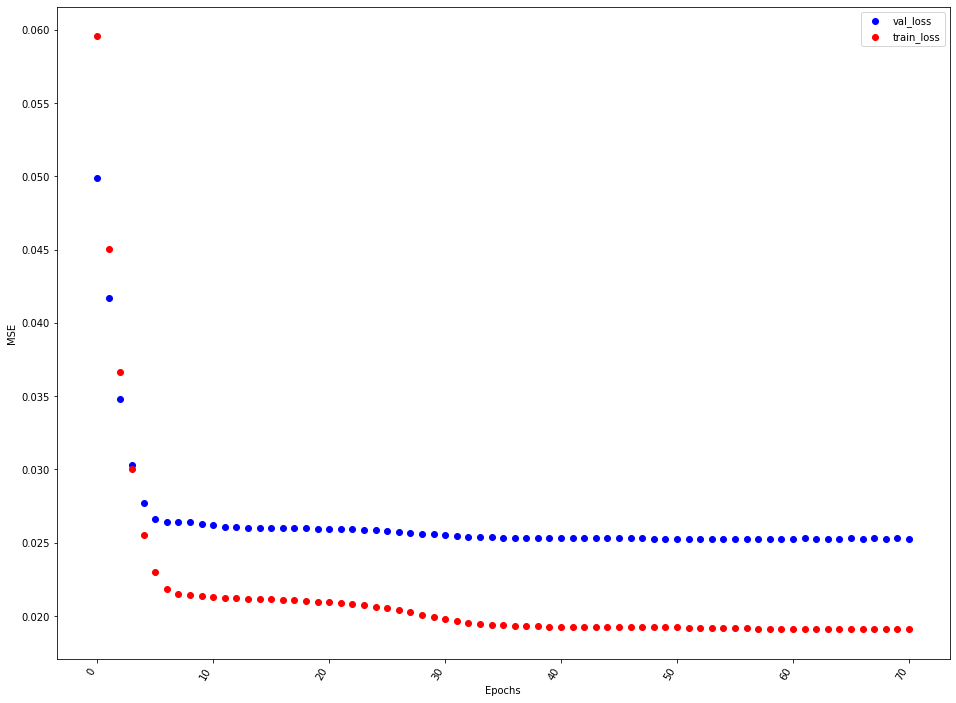

In [556]:
x_ax = [i for i in range(len(val_losses))]
mpl.rcParams['figure.figsize'] = (16, 12)

plt.scatter(x=x_ax, y=val_losses, color = 'b',label='val_loss')
plt.scatter(x=x_ax, y=train_loss, color = 'r', label='train_loss')
plt.xticks(rotation=60, ha='right')
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Evaluation

In [557]:
def evaluate(model, scaler, test_tf, test):
  """ Evaluate the trained local model on local test set, return predicstions and test MSE."""

  forecast = model.predict(test_tf)
  predictions = scaler.inverse_transform(forecast)
  pred_df = pd.DataFrame(data = predictions, columns = list(test.columns.values), index = test[TIME_WINDOW_SIZE:].index)

  test_metrics = round(mean_squared_error(test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS], pred_df.iloc[: , :NUMBER_OF_CLIENTS]), 5)
  test_metrics_pct = round(mean_absolute_percentage_error(test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS], pred_df.iloc[: , :NUMBER_OF_CLIENTS]), 5)
  r2 = round(r2_score(test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS], pred_df.iloc[: , :NUMBER_OF_CLIENTS]), 5)

  return pred_df, test_metrics, test_metrics_pct, r2

In [558]:
preds, mse, mape, r2 = evaluate(model, scaler, test_tf, test)

In [559]:
print(mse)
print(mape)
print(r2)

0.14852
7827857404592.144
-0.13128


In [560]:
test.iloc[TIME_WINDOW_SIZE: , :NUMBER_OF_CLIENTS].head()

,MAC001848,MAC001377,MAC002192,MAC001816,MAC002170,MAC004481,MAC001276,MAC001824,MAC004475,MAC001272,...,MAC001294,MAC002190,MAC001353,MAC001845,MAC001357,MAC002197,MAC004483,MAC004464,MAC002208,MAC001362
DateTime,,,,,,,,,,,,,,,,,,,,,
2013-06-14 18:00:00,0.121,0.291,0.083,0.269,0.668,0.090,0.010,0.228,0.063,0.089,...,0.193,0.470,0.164,0.501,0.153,0.057,0.755,0.776,0.624,0.000
2013-06-14 19:00:00,0.190,0.473,0.808,0.284,1.813,0.061,0.011,0.226,0.084,0.104,...,0.947,0.435,0.232,0.675,0.202,0.290,1.025,1.989,0.563,0.000
2013-06-14 20:00:00,0.191,0.639,0.549,0.207,0.954,0.161,0.010,0.339,0.214,0.201,...,0.366,0.504,0.206,0.375,0.764,0.037,0.599,0.961,0.438,0.000
2013-06-14 21:00:00,0.326,0.509,0.986,0.234,1.068,0.270,0.020,0.305,0.157,0.128,...,0.451,0.628,0.203,0.335,1.945,0.052,0.476,0.822,0.463,0.065
2013-06-14 22:00:00,0.289,0.974,0.694,0.143,1.400,0.180,0.011,0.259,0.074,0.087,...,0.234,0.573,0.202,0.361,1.829,0.048,0.524,0.820,0.616,0.132


In [561]:
preds.iloc[: , :NUMBER_OF_CLIENTS].head()

,MAC001848,MAC001377,MAC002192,MAC001816,MAC002170,MAC004481,MAC001276,MAC001824,MAC004475,MAC001272,...,MAC001294,MAC002190,MAC001353,MAC001845,MAC001357,MAC002197,MAC004483,MAC004464,MAC002208,MAC001362
DateTime,,,,,,,,,,,,,,,,,,,,,
2013-06-14 18:00:00,0.278399,0.401614,0.275499,0.174259,0.360423,0.199849,0.224072,0.593779,0.271633,0.113204,...,0.193274,0.555803,0.214270,0.217508,0.533040,0.177645,0.277488,0.336226,0.630254,0.075793
2013-06-14 19:00:00,0.279244,0.396611,0.269343,0.177057,0.354046,0.203206,0.211751,0.577532,0.262888,0.105774,...,0.192623,0.558211,0.211911,0.218483,0.542867,0.182298,0.279355,0.334976,0.627912,0.073150
2013-06-14 20:00:00,0.278637,0.391779,0.264583,0.180949,0.341084,0.207604,0.203249,0.562615,0.257558,0.094165,...,0.191250,0.556717,0.209228,0.223037,0.558871,0.179567,0.277715,0.331789,0.616732,0.073296
2013-06-14 21:00:00,0.275939,0.386725,0.260811,0.181856,0.327908,0.210659,0.190671,0.542985,0.252968,0.082708,...,0.190102,0.556556,0.203903,0.220847,0.571687,0.174278,0.277811,0.335390,0.608027,0.073076
2013-06-14 22:00:00,0.277358,0.389291,0.259326,0.179082,0.329836,0.208607,0.192533,0.546915,0.255447,0.085512,...,0.188006,0.553061,0.209917,0.219495,0.568109,0.166654,0.272836,0.337044,0.606881,0.074193


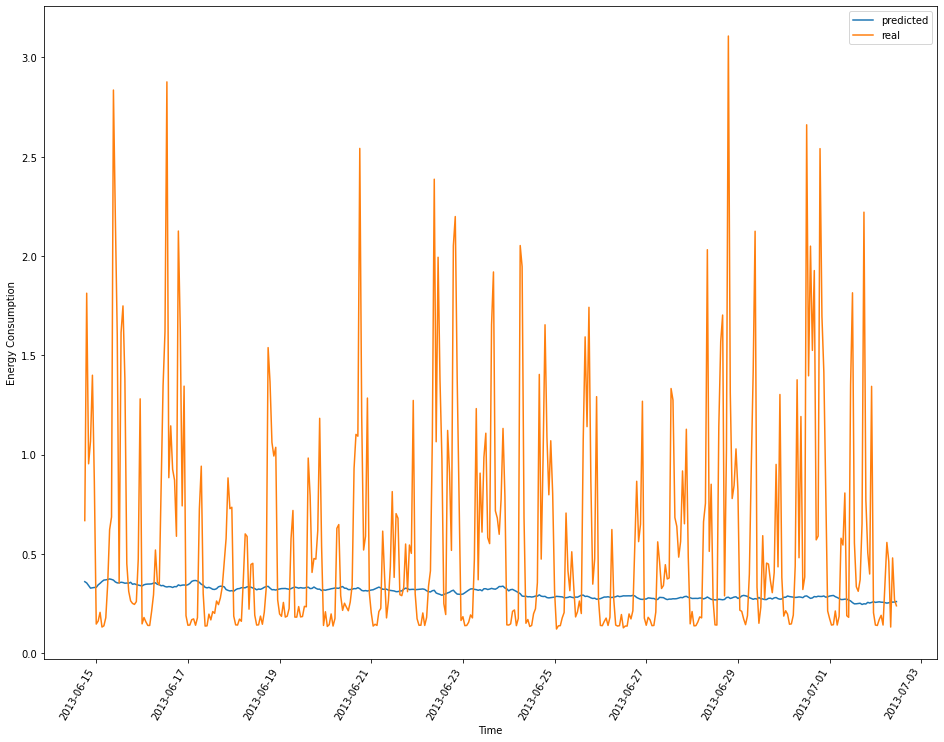

In [562]:
random_number = random.randint(0,NUMBER_OF_CLIENTS)
random_pred = preds.iloc[:, random_number]
random_true = test.iloc[TIME_WINDOW_SIZE:, random_number]

x_ax = list(preds.index)
mpl.rcParams['figure.figsize'] = (16, 12)

plt.plot(x_ax, random_pred, label='predicted')
plt.plot(x_ax, random_true, label='real')
plt.xticks(rotation=60, ha='right')
plt.ylabel("Energy Consumption")
plt.xlabel("Time")
plt.legend()
plt.show()